# In this notebook we use pictures form LFW dataset to verify the embedding classification accuracy of Facenet. We use MTCNN to extract face array from the image. Then we use Facenet to extract face embeddings from each face. Totally 400 pairs of images are classified for training and testing. The accuracy on training dataset is 97.9%, and the accuracy on test dataset is 97.5%.

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.5 MB/s 


In [ ]:
import os

import numpy as np
from numpy import expand_dims
import cv2

from keras.models import load_model
from sklearn.neighbors import NearestNeighbors
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from PIL import Image 
from numpy import savez_compressed
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
basepath = '/content/drive/My Drive/cmpe258/lfw'

In [ ]:
!ls '{basepath}/model'

facenet_keras.h5


#We use retrained Facenet model to extract embedding from the face image.

In [ ]:
# - Model input shape: [160, 160, 3]
# - Model output shape: [128]
SAVED_MODEL_PATH = f'{basepath}/model/facenet_keras.h5'
assert os.path.exists(SAVED_MODEL_PATH)

EMB_DIM = 128
print('SAVED_MODEL_PATH : {}'.format(SAVED_MODEL_PATH))

SAVED_MODEL_PATH : /content/drive/My Drive/cmpe258/lfw/model/facenet_keras.h5


In [ ]:
model = load_model(SAVED_MODEL_PATH, compile=False)

#We use LFW Dataset to train the classifier and test the performance. [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/)
LFW totally has 6000 pairs of labeled images. Due to limited computility, we use a subset of 400 paired images. 200 pairs labeled as same person, 200 labeled as different person.

In [ ]:
def get_img_pairs_list(pairs_csv_path,img_path):
    """ Giving a image pair info file, and image directory, return a list of all images' path
        Args:
            pairs_txt_path：pairs.csv，totaly 6000 image pairs.
            img_path：image directory
        return:
            img_pairs_list：2 level nested list of all image paths.
    """
    file = open(pairs_csv_path)
    line = file.readline()
    match_count = 0
    mismatch_count = 0
    img_pairs_list,labels = [],[]
    while 1:
        img_pairs = []
        line = file.readline().replace('\n','')
        if line == '':
            break
        if match_count == mismatch_count  and (match_count >= 200):
            break
        line_list = line.split(',')
        if (line_list[-1] == '') and (match_count < 200):
            img_pairs.append(img_path+line_list[0]+'/'+line_list[0]+'_'+('000'+line_list[1])[-4:]+'.jpg')
            img_pairs.append(img_path+line_list[0]+'/'+line_list[0]+'_'+('000'+line_list[2])[-4:]+'.jpg')
            match_count = match_count + 1
            labels.append(1)
        elif (line_list[-1] != '') and (mismatch_count < 200):
            img_pairs.append(img_path+line_list[0]+'/'+line_list[0]+'_'+('000'+line_list[1])[-4:]+'.jpg')
            img_pairs.append(img_path+line_list[2]+'/'+line_list[2]+'_'+('000'+line_list[3])[-4:]+'.jpg')
            mismatch_count = mismatch_count + 1
            labels.append(0)
        else:
            continue
        
        img_pairs_list.append(img_pairs)
    print('match pairs count:', match_count)
    print('mismatch pairs count:', mismatch_count)
    return img_pairs_list,labels


# We use MTCNN model to extract face eara image array from each LWF image.

In [ ]:
def extract_image(image):
  img1 = Image.open(image)            #open the image
  img1 = img1.convert('RGB')          #convert the image to RGB format 
  pixels = asarray(img1)              #convert the image to numpy array
  detector = MTCNN()                  #assign the MTCNN detector
  f = detector.detect_faces(pixels)
  #fetching the (x,y)co-ordinate and (width-->w, height-->h) of the image
  x1,y1,w,h = f[0]['box']             
  x1, y1 = abs(x1), abs(y1)
  x2 = abs(x1+w)
  y2 = abs(y1+h)
  #locate the co-ordinates of face in the image
  store_face = pixels[y1:y2,x1:x2]
  image1 = Image.fromarray(store_face,'RGB')    #convert the numpy array to object
  image1 = image1.resize((160,160))             #resize the image
  face_array = asarray(image1)                  #image to array
  return face_array

In [ ]:
img_pairs_list, labels = get_img_pairs_list(basepath+"/Labelled-Faces-in-the-Wild-LFW/pairs.csv", basepath+"/Labelled-Faces-in-the-Wild-LFW/lfw-deepfunneled/")

match pairs count: 200
mismatch pairs count: 200


In [ ]:
# 400 image path list(200 match and 200 mismatch)
len(img_pairs_list)

400

In [ ]:
# #Check extracted path list result 
# import pandas as pd
# df = pd.DataFrame(img_pairs_list, columns = ['first_img_path', 'second_img_path'])
# df.to_csv(basepath+'/output/test.csv')
# df_label = pd.DataFrame(labels, columns = ['label'])
# df_label.to_csv(basepath+'/output/labels.csv')

In [ ]:
#Generalize the data and extract the embeddings
def extract_embeddings(model,face_pixels):
  face_pixels = face_pixels.astype('float32')  #convert the entire data to float32(base)
  mean = face_pixels.mean()                    #evaluate the mean of the data
  std  = face_pixels.std()                     #evaluate the standard deviation of the data
  face_pixels = (face_pixels - mean)/std       
  samples = expand_dims(face_pixels,axis=0)    #expand the dimension of data 
  yhat = model.predict(samples)
  return yhat[0]

# Test MTCNN face detector and facenet embedding on test image

In [ ]:
pair = img_pairs_list[90]
first_face = extract_image(pair[0])
second_face = extract_image(pair[1])
first_emb = extract_embeddings(model, first_face)
second_emb = extract_embeddings(model, second_face)

1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 124ms/step


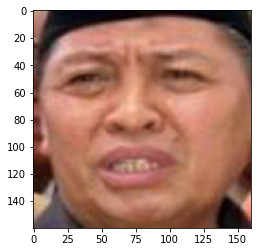

In [ ]:

plt.imshow(first_face)


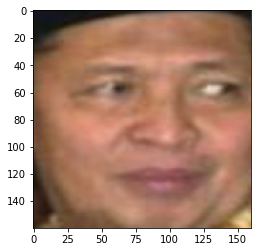

In [ ]:
plt.imshow(second_face)

In [ ]:
distance = np.sqrt(np.sum(np.square(np.subtract(first_emb, second_emb))))
distance

8.4817705

# Use MTCNN face detector and Facenet embedding to get distence from 400 image pairs

In [ ]:
dist = [] # Distance result list
total_num = len(img_pairs_list)

In [ ]:
# This step takes hours, so the prerun result is saved as .npy file. Reload from "basepath+'/output/distances.npy": 
for i in range(total_num):
  print(i)              
  img_pair = img_pairs_list[i]
  face_1 = extract_image(img_pair[0])
  face_2 = extract_image(img_pair[1])
  emb_1 = extract_embeddings(model, face_1)
  emb_2 = extract_embeddings(model, face_2)
  ed = np.sqrt(np.sum(np.square(np.subtract(emb_1, emb_2))))
  dist.append(ed)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 101ms/step
130
1/1 [==============================] - 0s 103ms/step
131
1/1 [==============================] - 0s 130ms/step
132
1/1 [==============================] - 0s 102ms/step
133
1/1 [==============================] - 0s 106ms/step
134
1/1 [==============================] - 0s 183ms/step
135
1/1 [==============================] - 0s 107ms/step
136
1/1 [==============================] - 0s 107ms/step
137
1/1 [==============================] - 0s 108ms/step
138
1/1 [==============================] - 0s 119ms/step
139
1/1 [==============================] - 0s 107ms/step
140
1/1 [==============================] - 0s 111ms/step
141
1/1 [==============================] - 0s 119ms/step
142
1/1 [==============================] - 0s 107ms/step
143
1/1 [==============================] - 0s 196ms/step
144
1/1 [==============================] - 0s 110ms/step
145
1/1 [==============================] 

In [ ]:
# np.save(basepath+'/output/distances', dist)


In [ ]:
dist = np.load(basepath+'/output/distances.npy')

# Split data for train and test

In [ ]:
dist_arr = np.array(dist)
label_arr = np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dist_arr, label_arr, test_size=0.30, random_state=42)

In [ ]:
len(X_train)

280

In [ ]:

len(X_test)

120

# A Simple classifier to binary classify the distance: "1"-same person; "0"- different person.

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', probability=False)

In [ ]:
clf.fit(X_train.reshape(-1,1), y_train)

SVC(kernel='linear')

In [ ]:
#predict
predict_train = clf.predict(X_train.reshape(-1,1))
predict_test = clf.predict(X_test.reshape(-1,1))

# Test result on both training dataset and test dataset. 
Accuracy score on training set: 97.9%
Accuracy score on test set: 97.5%

In [ ]:
from sklearn.metrics import accuracy_score, plot_roc_curve, auc
acc_train = accuracy_score(y_train, predict_train)
acc_train

0.9785714285714285

In [ ]:
acc_test = accuracy_score(y_test, predict_test)
acc_test

0.975

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


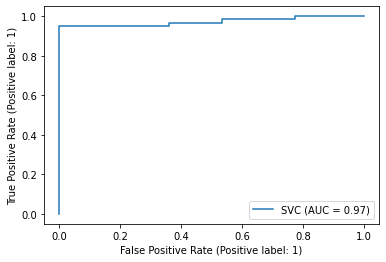

In [ ]:
plot_roc_curve(clf, X_test.reshape(-1,1), y_test)

#Predict any 2 images and show the result.

In [ ]:
def try_any_two_faces(img1, img2, model, clf):
  face1 = extract_image(img1);
  face2 = extract_image(img2);
  emb1 = extract_embeddings(model, face1)
  emb2 = extract_embeddings(model, face2)
  distance = np.sqrt(np.sum(np.square(np.subtract(emb1, emb2))))
  arr = np.array(distance)
  y = clf.predict(arr.reshape(-1,1))
  return face1, face2, distance, y

In [ ]:
face_1, face_2, distance, y = try_any_two_faces(basepath+"/sample_query_dataset/013.jpeg", basepath+"/sample_query_dataset/014.jpeg", model, clf)

1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 61ms/step


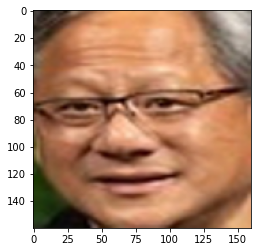

In [ ]:
plt.imshow(face_1)

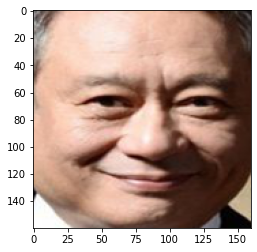

In [ ]:
plt.imshow(face_2)

In [ ]:
distance

11.91201

In [ ]:
y 

array([1])

This result is inaccurate.

# Try another pair.

In [ ]:
face_1, face_2, distance, y = try_any_two_faces(basepath+"/sample_query_dataset/010.JPG", basepath+"/sample_query_dataset/014.jpeg", model, clf)

1/1 [==============================] - 0s 60ms/step


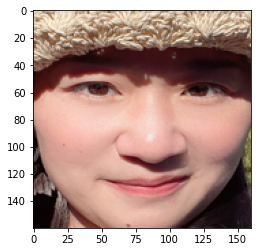

In [ ]:
plt.imshow(face_1)

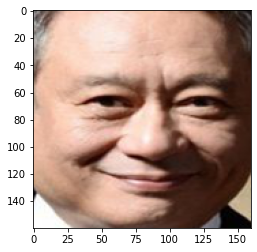

In [ ]:
plt.imshow(face_2)

In [ ]:
y

array([0])

This result is accurate.

#Upgrade the resize function and see if the result improves.

In [ ]:
#function to reshape a image array without changing the aspect ratio 
def resize_image(img, side):
  h, w = img.shape[0], img.shape[1]
  L = max(w, h)
  square_img = np.zeros((L, L, 3), np.uint8)
  square_img[(L-h)//2:(L+h)//2, (L-w)//2:(L+w)//2, ] = img
  new_img = cv2.resize(square_img, (side, side))
  return new_img


In [ ]:
#upgraded image extraction function
def extract_image_v2(image):
  img1 = Image.open(image)            #open the image
  img1 = img1.convert('RGB')          #convert the image to RGB format 
  pixels = asarray(img1)              #convert the image to numpy array
  detector = MTCNN()                  #assign the MTCNN detector
  f = detector.detect_faces(pixels)
  #fetching the (x,y)co-ordinate and (width-->w, height-->h) of the image
  x1,y1,w,h = f[0]['box']             
  x1, y1 = abs(x1), abs(y1)
  x2 = abs(x1+w)
  y2 = abs(y1+h)
  #locate the co-ordinates of face in the image
  store_face = pixels[y1:y2,x1:x2]
  image1 = Image.fromarray(store_face,'RGB')    #convert the numpy array to object
  face_array = asarray(image1) #image to array
  face_array_reshape = resize_image(face_array, 160)   #resize 
  plt.imshow(face_array_reshape)             
  return face_array_reshape

1/1 [==============================] - 0s 324ms/step


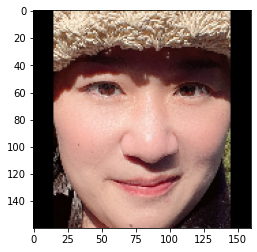

In [ ]:
test_face = extract_image_v2(basepath+"/sample_query_dataset/010.JPG")
plt.imshow(test_face)

In [ ]:
dist_v2 = []
total_num = len(img_pairs_list)
for i in range(total_num):
  print(i)              
  img_pair = img_pairs_list[i]
  face_1 = extract_image_v2(img_pair[0])
  face_2 = extract_image_v2(img_pair[1])
  emb_1 = extract_embeddings(model, face_1)
  emb_2 = extract_embeddings(model, face_2)
  ed = np.sqrt(np.sum(np.square(np.subtract(emb_1, emb_2))))
  dist_v2.append(ed)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 111ms/step
121
1/1 [==============================] - 0s 108ms/step
122
1/1 [==============================] - 0s 114ms/step
123
1/1 [==============================] - 0s 127ms/step
124
1/1 [==============================] - 0s 115ms/step
125
1/1 [==============================] - 0s 112ms/step
126
1/1 [==============================] - 0s 108ms/step
127
1/1 [==============================] - 0s 115ms/step
128
1/1 [==============================] - 0s 109ms/step
129
1/1 [==============================] - 0s 118ms/step
130
1/1 [==============================] - 0s 126ms/step
131
1/1 [==============================] - 0s 120ms/step
132
1/1 [==============================] - 0s 210ms/step
133
1/1 [==============================] - 0s 121ms/step
134
1/1 [==============================] - 0s 110ms/step
135
1/1 [==============================] - 0s 110ms/step
136
1/1 [==============================] 

In [ ]:
# np.save(basepath+'/output/distances_v2', dist_v2)

In [ ]:
len(dist_v2)

400

In [ ]:
dist_v2 = np.load(basepath+'/output/distances_v2.npy')

In [ ]:
#Train SVC model to binary classifiy the distance
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_roc_curve, auc

dist_arr = np.array(dist_v2)
label_arr = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(dist_arr, label_arr, test_size=0.30, random_state=42)
clf = SVC(kernel='linear', probability=False)
clf.fit(X_train.reshape(-1,1), y_train)

SVC(kernel='linear')

In [ ]:
#predict
predict_train = clf.predict(X_train.reshape(-1,1))
predict_test = clf.predict(X_test.reshape(-1,1))

acc_train = accuracy_score(y_train, predict_train)
acc_test = accuracy_score(y_test, predict_test)
print("Accuracy score on train dataset(size 280):", acc_train)
print("Accuracy scroe on test dataset(size 120):", acc_test)

Accuracy score on train dataset(size 280): 0.9785714285714285
Accuracy scroe on test dataset(size 120): 0.9583333333333334


We don't see imporvement on the test dataset. One possible reason is the embedding model is not sensitive to the face picture ratio. The other reason maybe the limited test dataset size.

# Future explore...
* Use larger dataset size.
* Use Cosine Distance instead of Euclidean Distance to compare 2 embeddings. 
* Use PCA to reduce feature dimensions.